In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sys
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error as mse
from importlib import reload
import scipy.io
import matplotlib.cm as cm
import pickle
import matplotlib as mpl
import shutil
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(tf.__version__)
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization,Input
from tensorflow.keras.models import load_model, Model,Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger,ReduceLROnPlateau
gpus = tf.config.experimental.list_physical_devices('GPU') 
from sklearn.metrics import r2_score, mean_squared_error
if gpus:
    try:
        for gpu in gpus:
            limit =  8192# 10G memory per GPU
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=limit)]
            )
        tf.config.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2.15.0


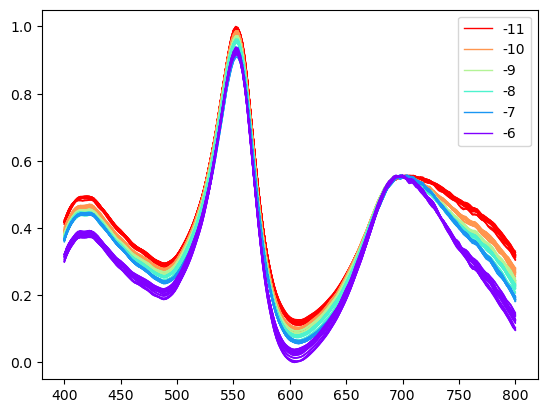

In [6]:
test_split_method = 'batch'
remove_concentration= [0]
data_dir = './data/dopamine_uric/'
wls = np.loadtxt(data_dir+'wavelengths.txt')
X_an = np.load(data_dir+'X.npy')
df = pd.read_csv(data_dir+'labels.csv')
df['status'] = 'train'
if test_split_method == 'batch':
    for concentration in df['concentration'].unique():
        # Get unique batches for this concentration
        batches = df[df['concentration'] == concentration]['batch'].unique()
        # Randomly select 1/4 of these batches for the test set, minimum 1
        test_batches = np.random.choice(batches, max(1, len(batches) // 4), replace=False)
        # Label the selected batches as 'test'
        df.loc[(df['concentration'] == concentration) & (df['batch'].isin(test_batches)), 'status'] = 'test'
elif test_split_method== 'sample':
    # Randomly select 1/4 of the samples for the test set, minimum 1
    test_samples = np.random.choice(df.index, max(1, len(df) // 5), replace=False)
    df.loc[df.index.isin(test_samples), 'status'] = 'test'
df = df[~df['concentration'].isin(remove_concentration)]
X_an = X_an.reshape(-1,201)[df.index]
X_an = X_an.reshape(-1,30,201)
c_list = np.unique(df.concentration)
colors = cm.rainbow_r(np.linspace(0, 1, len(c_list)))
for c in range(len(X_an)):
    legend_flag = 1
    for b in np.arange(0,30):
        if legend_flag:
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=1,linewidth=1,label=c_list[c])
            legend_flag = 0
        else:
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=1,linewidth=1)
plt.legend()

In [7]:
X = X_an.reshape(len(c_list)*30,-1)
Y = np.array(df.concentration)
Y_reg = (Y-Y.min()) / (Y.max()-Y.min())

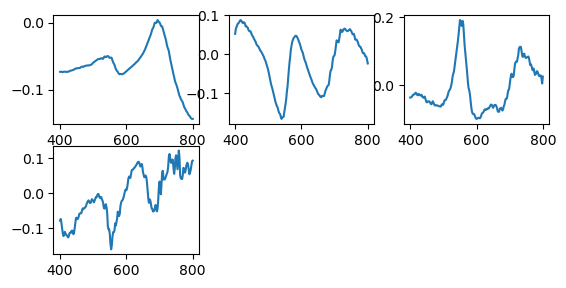

In [9]:
pca = PCA(n_components=8, svd_solver='full')
pc=pca.fit_transform(X)
pca_components = pca.components_
for i in range(4):
    plt.subplot(3,3,i+1)
    plt.plot(wls,pca_components[i])
np.save(data_dir+'pca4.npy',pca_components)

In [24]:
from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y_reg, test_size=0.2)
X_train = X[df.status=='train']
Y_train = Y_reg[df.status=='train']
X_test = X[df.status=='test']
Y_test = Y_reg[df.status=='test']

N_PCA=8
early_stopper = EarlyStopping(monitor='loss',patience=15)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=0,
                              patience=4, min_lr=1e-6)
model=Sequential(name='test')
#model.add(BatchNormalization())
model.add(Dense(32,activation='relu',input_shape=(N_PCA,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
# model.add(Dense(16,activation='relu',input_shape=(N_PCA,)))
# model.add(Dense(16,activation='relu'))
# model.add(Dense(32,activation='relu'))
# model.add(Dense(1,activation='sigmoid'))
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse',metrics='mae')
#model.summary()
#pca = PCA(n_components=N_PCA, svd_solver='full')
#pc=pca.fit_transform(X_train)
# pca.fit(X_train)
pca_components = np.load(data_dir+'pca8.npy')
pc = np.matmul(X_train,pca_components.T)

pc1 = (pc-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
history=model.fit(pc1,Y_train,epochs=100,verbose=0,batch_size=8,
                  callbacks=[reduce_lr,early_stopper])
#plt.plot(history.history['loss'])

2/2 [==============================] - 0s 1ms/step


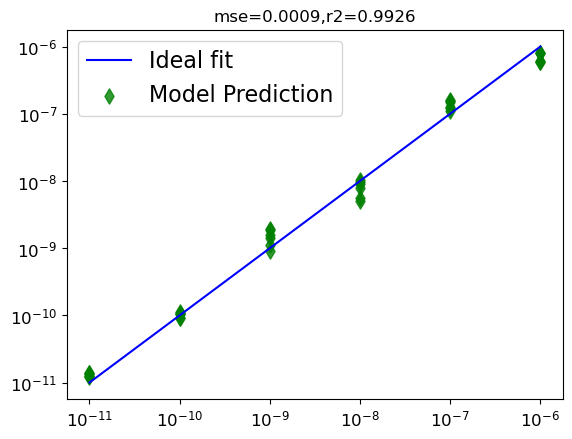

In [28]:
#model=load_model('models/uric9926.h5')
def unnorm(y):
    return y * (Y.max() - Y.min())+Y.min()
from sklearn.metrics import r2_score, mean_squared_error
# pc_test =pca.transform(X_test)
pc_test=np.matmul(X_test,pca_components.T)
pc_test=(pc_test-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
#error = model.evaluate(pc_test,Y_test)
Y_pred = model.predict(pc_test)
test_r2=r2_score(unnorm(Y_test),unnorm(Y_pred))
error = mean_squared_error(Y_test,Y_pred)
alp=0.8
s=60
#min_concentration = np.max(c_list) * -1
x_ax=np.arange(np.min(c_list),np.max(c_list)  +1)
plt.plot(x_ax,x_ax,'b')
plt.scatter(unnorm(Y_test),unnorm(Y_pred),marker='d',color='green',alpha=alp,s=s)
plt.legend(['Ideal fit','Model Prediction'],fontsize=16)
ticks=[]
for c in x_ax:
    ticks.append("$10^{"+str(c)+"}$")
plt.xticks(1*x_ax,ticks,fontsize=12)
plt.yticks(1*x_ax,ticks,fontsize=12)
plt.title('mse={:.4f},r2={:.4f}'.format(error,test_r2))
r2_text = "{:.4f}".format(test_r2)
r2_text = r2_text [2:]
#model.save(f'models/uric{r2_text}.h5')

In [30]:
## Importance Analysis
from importance_analysis import *
ig_data = pc
imp_scores = []
for i in range(len(ig_data)):
    input_vector = ig_data[i]
    imp_score = zero_baseline_integrated_gradients(input_vector, model, num_steps=30, num_runs=5)
    imp_scores.append(imp_score.numpy())
imp_scores = np.array(imp_scores)
print(np.mean(imp_scores,axis=0),'\n',np.std(imp_scores,axis=0))
print(np.argsort(np.abs(np.mean(imp_scores,axis=0)))[::-1])
np.savetxt('IGs/uric_zero.txt',np.mean(imp_scores,axis=0))

2.15.0
[ 0.34287897 -0.01486596  0.02061166  0.02679203  0.07353289 -0.14455408
 -0.01700147 -0.00369104] 
 [0.01100977 0.0015894  0.00274871 0.00358545 0.0055552  0.0187418
 0.0028614  0.00020665]
[0 5 4 3 2 6 1 7]


In [32]:
## Importance Analysis
from importance_analysis import *
ig_data = np.concatenate([pc,pc_test],axis=0)
imp_scores = []
for i in range(len(ig_data)):
    input_vector = ig_data[i]
    #imp_score = zero_baseline_integrated_gradients(input_vector, model, num_steps=20, num_runs=2)
    imp_score = random_baseline_integrated_gradients(input_vector, model, num_steps=30, num_runs=10)
    imp_scores.append(imp_score.numpy())
imp_scores = np.array(imp_scores)
print(np.mean(imp_scores,axis=0),'\n',np.std(imp_scores,axis=0))
print(np.argsort(np.abs(np.mean(imp_scores,axis=0)))[::-1])
s=np.abs(np.mean(imp_scores,axis=0))
np.savetxt('IGs/uric_random.txt',np.mean(imp_scores,axis=0))

[ 0.50873905 -0.02634549 -0.01027591 -0.04172486  0.02210151 -0.05251666
 -0.02596322  0.00148529] 
 [0.255844   0.01755917 0.0376446  0.08140934 0.01995179 0.03382856
 0.01652728 0.00540704]
[0 5 3 1 6 4 2 7]


IMP=0.8711623696802285, VAR=0.963993824434442


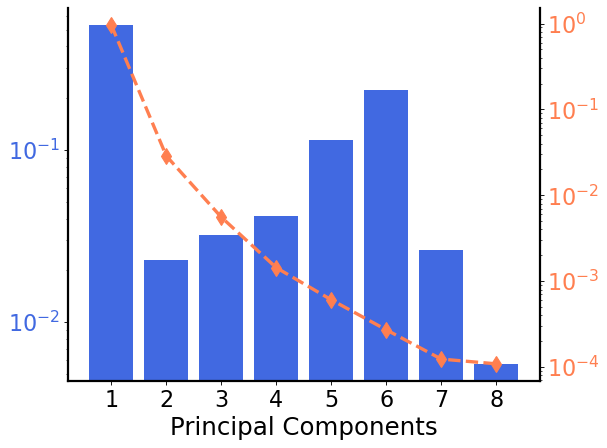

In [33]:
d1 = np.abs(np.loadtxt('IGs/uric_zero.txt'))
plt.rcParams["font.size"]=20
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["ps.useafm"] = True
plt.rcParams["font.family"]='sans-serif'
d2 = pca.explained_variance_  # Second dataset with a different scale

x = np.arange(len(d1))  # Common x-axis for both datasets

fig, ax1 = plt.subplots(figsize=(8, 6),dpi=80)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
color = 'royalblue'
ax1.set_xlabel('Principal Components',fontsize=22)
#ax1.set_ylabel('Importance Score',fontsize=16)
ax1.bar(x, d1/np.sum(d1),color=color,label='Importance Score')
ax1.semilogy()
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(np.arange(0,8),np.arange(0,8)+1)
#ax1.tick_params(axis='x', labelsize=14)
#ax1.legend()

# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
color = 'coral'
#ax2.set_ylabel('Variance',fontsize=16)
ax2.plot(x, d2/np.sum(d2),color=color,marker='d',linestyle='--',markersize=10,linewidth=3,label='Variance')
ax2.semilogy()
ax2.tick_params(axis='y', labelcolor=color)
#plt.legend()
fig.tight_layout()  # Adjust the layout to make room for the second y-axis
chosen_pc = np.argsort(d1)[::-1][:3]
total_imp=np.sum(d1[chosen_pc])/np.sum(d1)
total_var = np.sum(pca.explained_variance_[chosen_pc])/np.sum(pca.explained_variance_)
print(f'IMP={total_imp}, VAR={total_var}')
plt.show()
